<a href="https://colab.research.google.com/github/bernicegolomo/student_trend/blob/main/student_progress_trend_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load and process dataset

In [ ]:
data = pd.read_csv('sample_data/scores.csv')

# Basic exploration
print(data.info())          # Data types and non-null values
print(data.describe())      # Summary statistics
print(data.head())          # First few rows
print(data['Trend'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20017 entries, 0 to 20016
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Student ID  20017 non-null  int64 
 1   Subject     20012 non-null  object
 2   Session ID  20017 non-null  int64 
 3   Exam ID     20017 non-null  int64 
 4   1           20017 non-null  int64 
 5   2           20017 non-null  int64 
 6   3           20017 non-null  int64 
 7   Trend       20017 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.2+ MB
None
         Student ID    Session ID       Exam ID             1             2  \
count  20017.000000  20017.000000  20017.000000  20017.000000  20017.000000   
mean     742.436979      2.821352     11.416096     64.823450     64.353799   
std      255.081476      1.082183      4.974974     25.674107     26.367829   
min       67.000000      1.000000      1.000000      0.000000      0.000000   
25%      588.000000      2.000000      9.0

# Split the dataset into features (X) and target variable (y)

In [ ]:
X = data.drop(columns=['Trend'])  # Features (remove 'Trend')
y = data['Trend']  # Target variable

# Handle categorical variables using One-Hot Encoding

In [ ]:
X = pd.get_dummies(X, drop_first=True)

# Handle missing values (if any)

In [ ]:
X.fillna(0, inplace=True)

# Standardize the features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# Handling class imbalance using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define models for the Voting Classifier

In [ ]:
logistic_model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Voting Classifier combining Logistic Regression and Random Forest
voting_model = VotingClassifier(estimators=[
    ('logistic', logistic_model),
    ('random_forest', rf_model)
], voting='soft')


# Hyperparameter tuning using GridSearchCV

In [ ]:
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength for Logistic Regression
    'random_forest__n_estimators': [50, 100, 200],  # Number of trees in Random Forest
    'random_forest__max_depth': [None, 10, 20, 30],  # Depth of trees in Random Forest
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=voting_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


# Evaluate the model on the test data

In [ ]:
y_pred = best_model.predict(X_test)

# Print the classification report

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.8459040959040959
Precision: 0.8478685835514488
Recall: 0.8459040959040959
F1-Score: 0.8444819571533374
Confusion Matrix:
 [[ 748   36   12  175]
 [  71  838    6  164]
 [   0    0  336    0]
 [  52   92    9 1465]]
Classification Report:
                   precision    recall  f1-score   support

          decline       0.86      0.77      0.81       971
      improvement       0.87      0.78      0.82      1079
insufficient data       0.93      1.00      0.96       336
            mixed       0.81      0.91      0.86      1618

         accuracy                           0.85      4004
        macro avg       0.87      0.86      0.86      4004
     weighted avg       0.85      0.85      0.84      4004



# Plot the confusion matrix


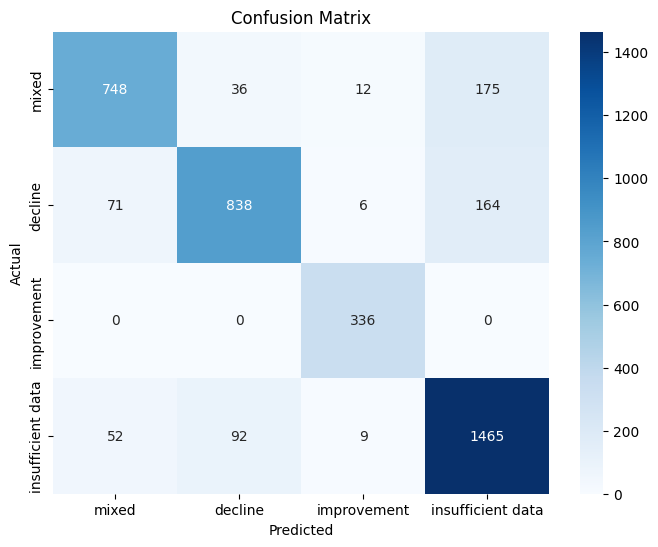

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model, scaler, and the column names for future use


In [ ]:
joblib.dump(best_model, 'best_trend_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns, 'encoded_columns.pkl')  # Save column names for future use

print("Model training and saving complete.")